In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,zoomed_inset_axes
import seaborn as sns

from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.nonparametric.api as smnp

%matplotlib notebook

In [125]:
ps1_white_phot = fits.getdata("COSMOS_compare_white_phot_adamamiller.fit")

The first step is to create some filters so that apples to apples comparisons can be done between the 3 different photometry methods from PS1.

In [126]:
print("Of the {:d} unique sources in the COSMOS cross-match:".format(len(ps1_white_phot)))
print("\tThere are {:d} sources with Mean white phot,".format(sum(~np.isnan(ps1_white_phot["wwMeanPSFFlux"]))))
print("\tThere are {:d} sources with Forced white phot,".format(sum(~np.isnan(ps1_white_phot["wwFPSFFlux"]))))
print("\tThere are {:d} sources with Stacked white phot.".format(sum(~np.isnan(ps1_white_phot["wwPSFFlux"]))))

Of the 80974 unique sources in the COSMOS cross-match:
	There are 42687 sources with Mean white phot,
	There are 80865 sources with Forced white phot,
	There are 75927 sources with Stacked white phot.


In [127]:
wwMeanPSFKronRatio = ps1_white_phot["wwMeanPSFFlux"]/ps1_white_phot["wwMeanKronFlux"]
wwFPSFKronRatio = ps1_white_phot["wwFPSFFlux"]/ps1_white_phot["wwFKronFlux"]
wwPSFKronRatio = ps1_white_phot["wwPSFFlux"]/ps1_white_phot["wwKronFlux"]

det_mfs = np.where(np.isfinite(wwMeanPSFKronRatio) & 
                   np.isfinite(wwFPSFKronRatio) & 
                   np.isfinite(wwPSFKronRatio))
det_mfs_star = np.where(np.isfinite(wwMeanPSFKronRatio) & 
                        np.isfinite(wwFPSFKronRatio) & 
                        np.isfinite(wwPSFKronRatio) & 
                        (ps1_white_phot["mu_class"] == 2) &
                        (wwMeanPSFKronRatio <= 2.0))
det_mfs_gal = np.where(np.isfinite(wwMeanPSFKronRatio) & 
                        np.isfinite(wwFPSFKronRatio) & 
                        np.isfinite(wwPSFKronRatio) & 
                        (ps1_white_phot["mu_class"] == 1) &
                        (wwMeanPSFKronRatio <= 2.0))

det_fs = np.where(np.isfinite(wwFPSFKronRatio) & 
                  np.isfinite(wwPSFKronRatio))
det_fs_star = np.where(np.isfinite(wwFPSFKronRatio) & 
                       np.isfinite(wwPSFKronRatio) & 
                       (ps1_white_phot["mu_class"] == 2) )
det_fs_gal = np.where(np.isfinite(wwFPSFKronRatio) & 
                      np.isfinite(wwPSFKronRatio) & 
                      (ps1_white_phot["mu_class"] == 1) )

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less_equal
/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal


#### Examine the PSF to Aperture ratio 

In [128]:
wwMeanPSFApRatio = ps1_white_phot["wwMeanPSFFlux"]/ps1_white_phot["wwMeanApFlux"]
wwFPSFApRatio = ps1_white_phot["wwFPSFFlux"]/ps1_white_phot["wwFApFlux"]
wwPSFApRatio = ps1_white_phot["wwPSFFlux"]/ps1_white_phot["wwApFlux"]

psfap_mfs = np.where(np.isfinite(wwMeanPSFApRatio) & 
                   np.isfinite(wwFPSFApRatio) & 
                   np.isfinite(wwPSFApRatio))
psfap_mfs_star = np.where(np.isfinite(wwMeanPSFApRatio) & 
                        np.isfinite(wwFPSFApRatio) & 
                        np.isfinite(wwPSFApRatio) & 
                        (ps1_white_phot["mu_class"] == 2) &
                        (wwMeanPSFApRatio <= 2.0))
psfap_mfs_gal = np.where(np.isfinite(wwMeanPSFApRatio) & 
                        np.isfinite(wwFPSFApRatio) & 
                        np.isfinite(wwPSFApRatio) & 
                        (ps1_white_phot["mu_class"] == 1) &
                        (wwMeanPSFApRatio <= 2.0))

psfap_fs = np.where(np.isfinite(wwFPSFApRatio) & 
                  np.isfinite(wwPSFApRatio))
psfap_fs_star = np.where(np.isfinite(wwFPSFApRatio) & 
                       np.isfinite(wwPSFApRatio) & 
                       (ps1_white_phot["mu_class"] == 2) )
psfap_fs_gal = np.where(np.isfinite(wwFPSFApRatio) & 
                      np.isfinite(wwPSFApRatio) & 
                      (ps1_white_phot["mu_class"] == 1) )

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less_equal
/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal


# Part 1 - Bright Sources Detected in Single Exposures

## Plot distance vs. Kron mag for 3 different phot measures

Show the distribution of these sources in their respective PSF vs. Kron planes.

In [129]:
ps1_df = Table.read("COSMOS_compare_white_phot_adamamiller.fit").to_pandas()

ps1_df["MeanDist"] = (ps1_white_phot["wwMeanPSFFlux"] - ps1_white_phot["wwMeanKronFlux"])/np.sqrt(2)
ps1_df["FDist"] = (ps1_white_phot["wwFPSFFlux"] - ps1_white_phot["wwFKronFlux"])/np.sqrt(2)
ps1_df["Dist"] = (ps1_white_phot["wwPSFFlux"] - ps1_white_phot["wwKronFlux"])/np.sqrt(2)

ps1_df["psfapMeanDist"] = (ps1_white_phot["wwMeanPSFFlux"] - ps1_white_phot["wwMeanApFlux"])/np.sqrt(2)
ps1_df["psfapFDist"] = (ps1_white_phot["wwFPSFFlux"] - ps1_white_phot["wwFApFlux"])/np.sqrt(2)
ps1_df["psfapDist"] = (ps1_white_phot["wwPSFFlux"] - ps1_white_phot["wwApFlux"])/np.sqrt(2)

ps1_df["MeanKronMag"] = -2.5*np.log10(ps1_white_phot["wwMeanKronFlux"]/3631)
ps1_df["FKronMag"] = -2.5*np.log10(ps1_white_phot["wwFKronFlux"]/3631)
ps1_df["KronMag"] = -2.5*np.log10(ps1_white_phot["wwKronFlux"]/3631)


In [130]:
def kde_contour_dat(x, y, extent = (0,0,0,0), bw_type = "silverman", grid_bins = 100):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == (0,0,0,0):
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

In [131]:
gal_dist_mean = ps1_df.ix[det_mfs_gal]["MeanDist"]
gal_mag_mean = ps1_df.ix[det_mfs_gal]["MeanKronMag"]

star_dist_mean = ps1_df.ix[det_mfs_star]["MeanDist"]
star_mag_mean = ps1_df.ix[det_mfs_star]["MeanKronMag"]

xgal_mean, ygal_mean, zgal_mean = kde_contour_dat(gal_mag_mean, gal_dist_mean, extent = (16,24,-2e-5,2e-5))
xstar_mean, ystar_mean, zstar_mean = kde_contour_dat(star_mag_mean, star_dist_mean, extent = (16,24,-2e-5,2e-5))

gal_dist_forced = ps1_df.ix[det_mfs_gal]["FDist"]
gal_mag_forced = ps1_df.ix[det_mfs_gal]["FKronMag"]

star_dist_forced = ps1_df.ix[det_mfs_star]["FDist"]
star_mag_forced = ps1_df.ix[det_mfs_star]["FKronMag"]

xgal_forced, ygal_forced, zgal_forced = kde_contour_dat(gal_mag_forced, gal_dist_forced, extent = (16,24,-2e-5,2e-5))
xstar_forced, ystar_forced, zstar_forced = kde_contour_dat(star_mag_forced, star_dist_forced, extent = (16,24,-2e-5,2e-5))

gal_dist_stacked = ps1_df.ix[det_mfs_gal]["Dist"]
gal_mag_stacked = ps1_df.ix[det_mfs_gal]["KronMag"]

star_dist_stacked = ps1_df.ix[det_mfs_star]["Dist"]
star_mag_stacked = ps1_df.ix[det_mfs_star]["KronMag"]

xgal_stacked, ygal_stacked, zgal_stacked = kde_contour_dat(gal_mag_stacked, gal_dist_stacked, extent = (16,24,-2e-5,2e-5))
xstar_stacked, ystar_stacked, zstar_stacked = kde_contour_dat(star_mag_stacked, star_dist_stacked, extent = (16,24,-2e-5,2e-5))

#### Get KDEs for Ap phot

In [132]:
gal_dist_mean_psfap = ps1_df.ix[psfap_mfs_gal]["psfapMeanDist"]
gal_mag_mean_psfap = ps1_df.ix[psfap_mfs_gal]["MeanKronMag"]

star_dist_mean_psfap = ps1_df.ix[psfap_mfs_star]["psfapMeanDist"]
star_mag_mean_psfap = ps1_df.ix[psfap_mfs_star]["MeanKronMag"]

xgal_mean_psfap, ygal_mean_psfap, zgal_mean_psfap = kde_contour_dat(gal_mag_mean_psfap, gal_dist_mean_psfap, extent = (16,24,-2e-5,2e-5))
xstar_mean_psfap, ystar_mean_psfap, zstar_mean_psfap = kde_contour_dat(star_mag_mean_psfap, star_dist_mean_psfap, extent = (16,24,-2e-5,2e-5))

gal_dist_forced_psfap = ps1_df.ix[psfap_mfs_gal]["psfapFDist"]
gal_mag_forced_psfap = ps1_df.ix[psfap_mfs_gal]["FKronMag"]

star_dist_forced_psfap = ps1_df.ix[psfap_mfs_star]["psfapFDist"]
star_mag_forced_psfap = ps1_df.ix[psfap_mfs_star]["FKronMag"]

xgal_forced_psfap, ygal_forced_psfap, zgal_forced_psfap = kde_contour_dat(gal_mag_forced_psfap, gal_dist_forced_psfap, extent = (16,24,-2e-5,2e-5))
xstar_forced_psfap, ystar_forced_psfap, zstar_forced_psfap = kde_contour_dat(star_mag_forced_psfap, star_dist_forced_psfap, extent = (16,24,-2e-5,2e-5))

gal_dist_stacked_psfap = ps1_df.ix[psfap_mfs_gal]["psfapDist"]
gal_mag_stacked_psfap = ps1_df.ix[psfap_mfs_gal]["KronMag"]

star_dist_stacked_psfap = ps1_df.ix[psfap_mfs_star]["psfapDist"]
star_mag_stacked_psfap = ps1_df.ix[psfap_mfs_star]["KronMag"]

xgal_stacked_psfap, ygal_stacked_psfap, zgal_stacked_psfap = kde_contour_dat(gal_mag_stacked_psfap, gal_dist_stacked_psfap, extent = (16,24,-2e-5,2e-5))
xstar_stacked_psfap, ystar_stacked_psfap, zstar_stacked_psfap = kde_contour_dat(star_mag_stacked_psfap, star_dist_stacked_psfap, extent = (16,24,-2e-5,2e-5))

<IPython.core.display.Javascript object>


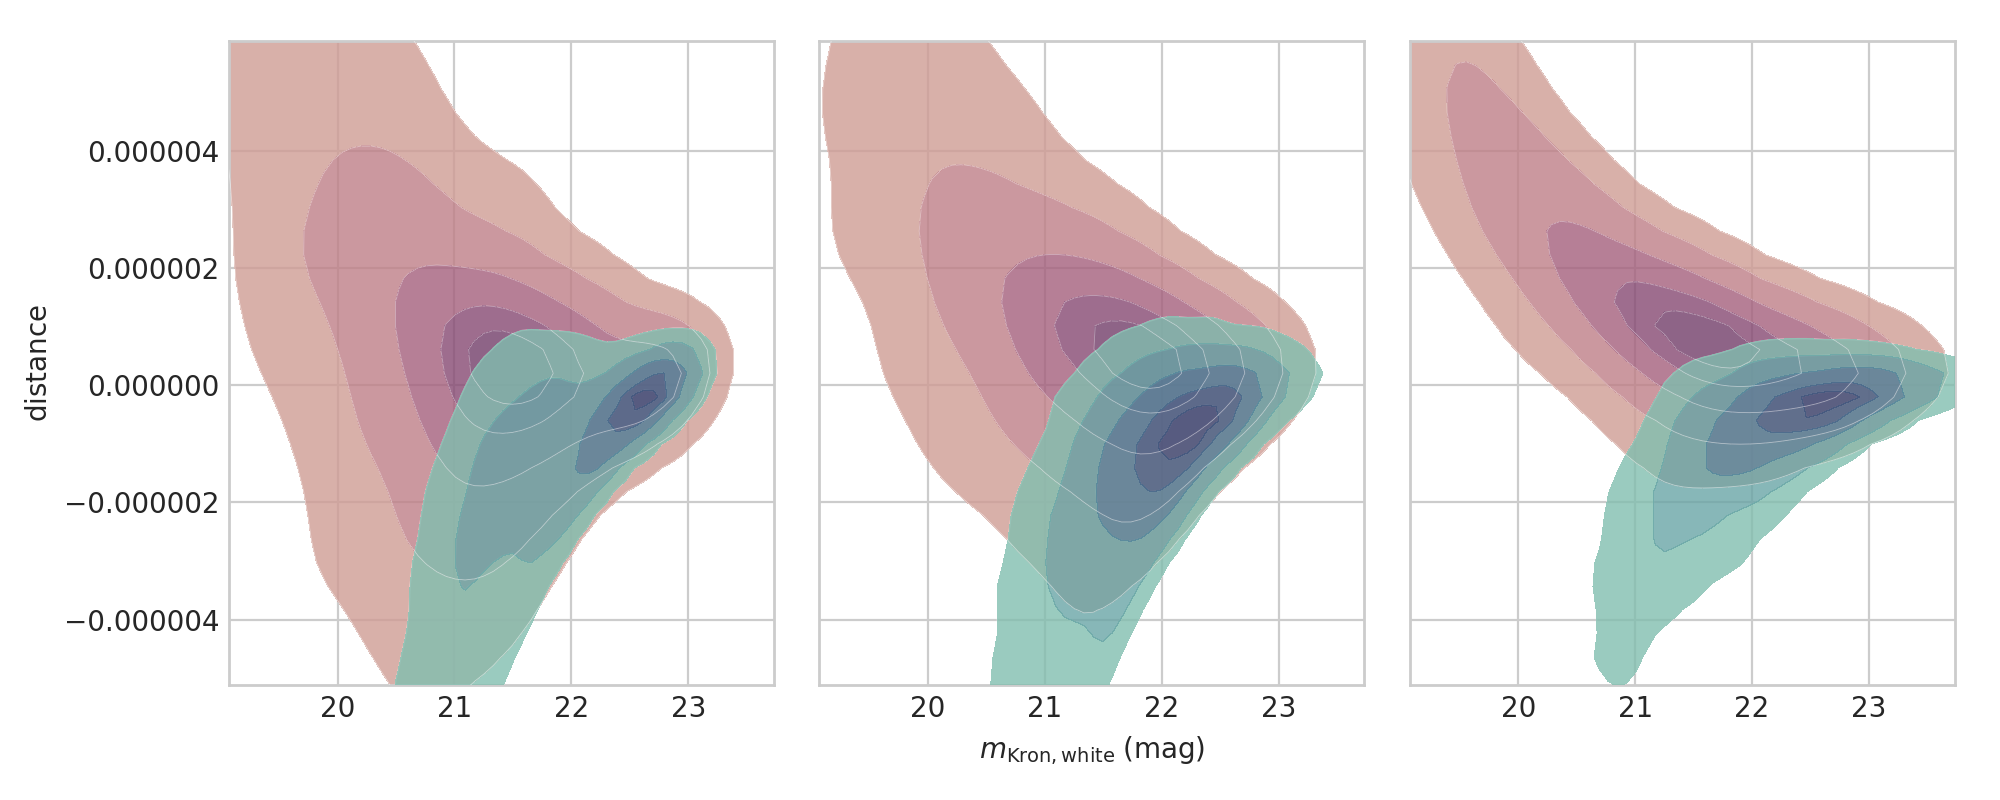

In [142]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_mean, ystar_mean, zstar_mean, xgal_mean, ygal_mean, zgal_mean), 
                                                                     (xstar_forced, ystar_forced, zstar_forced, xgal_forced, ygal_forced, zgal_forced), 
                                                                     (xstar_stacked, ystar_stacked, zstar_stacked,xgal_stacked, ygal_stacked, zgal_stacked)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 24)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

<IPython.core.display.Javascript object>


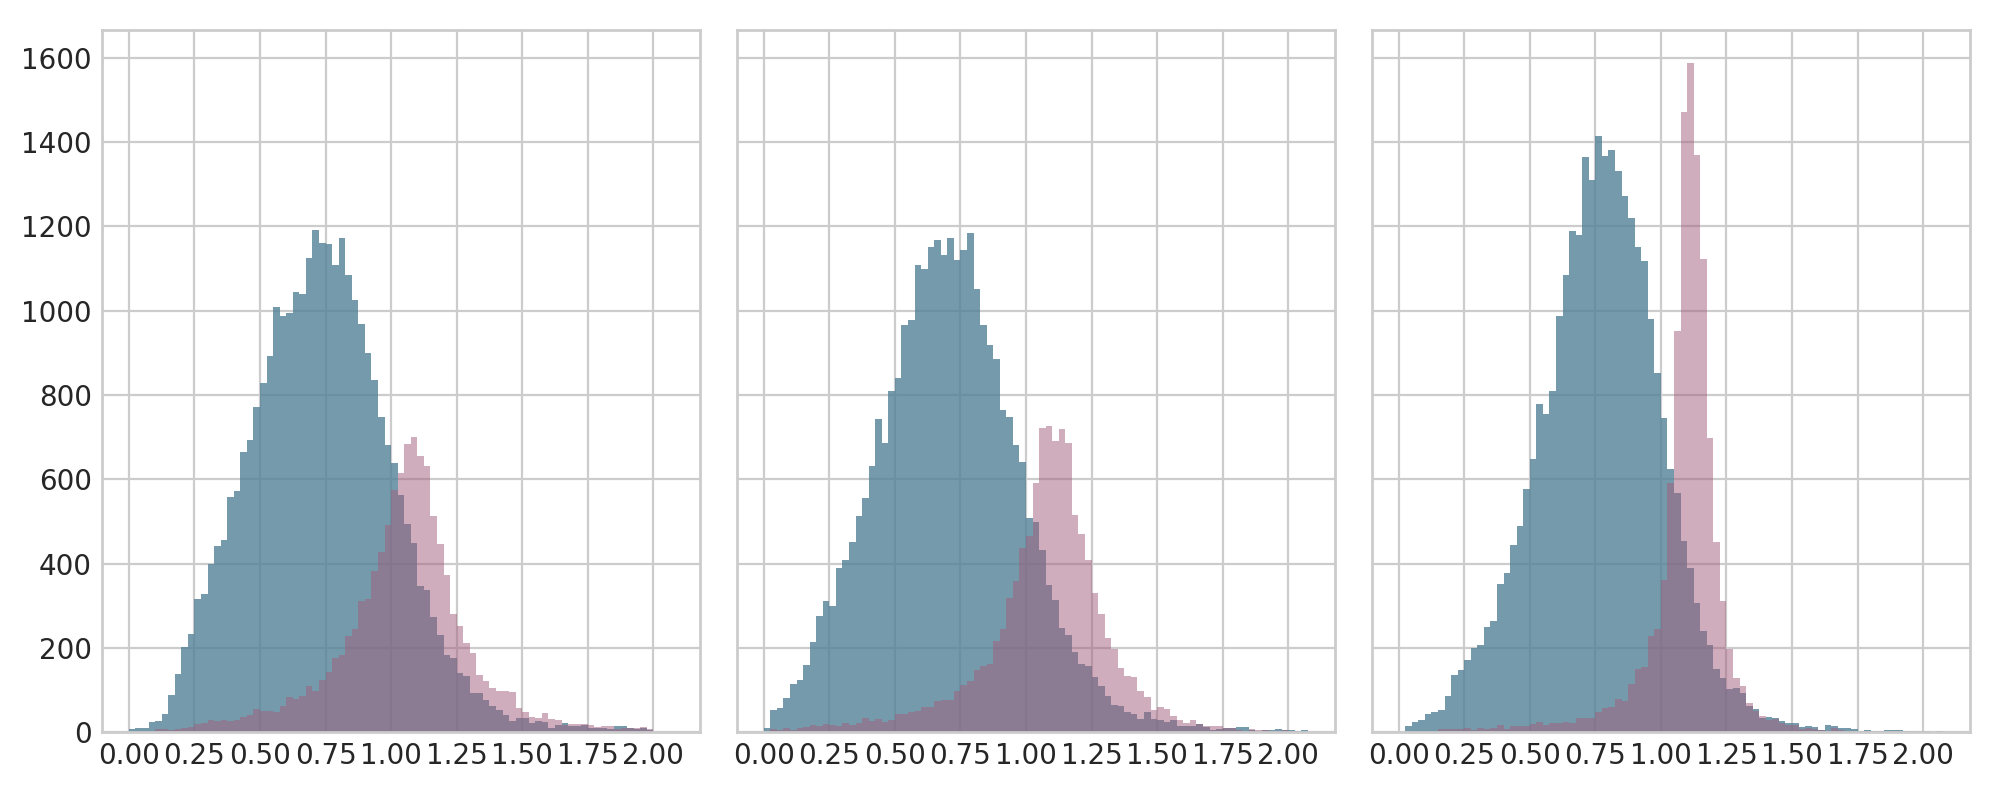

In [138]:
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, flux_ratio in enumerate([wwMeanPSFKronRatio, wwFPSFKronRatio, wwPSFKronRatio]):
        axes[axnum].hist(flux_ratio[det_mfs_gal], 
                         alpha=0.8, bins=np.arange(0,2.1,0.025), 
                         color = cmap_gal(0.6))
        axes[axnum].hist(flux_ratio[det_mfs_star], 
                         alpha=0.5, bins=np.arange(0,2.1,0.025), 
                         color = cmap_star(0.6))
    axes[0].set_xticks(np.linspace(0,2,9))
    fig.tight_layout()

<IPython.core.display.Javascript object>


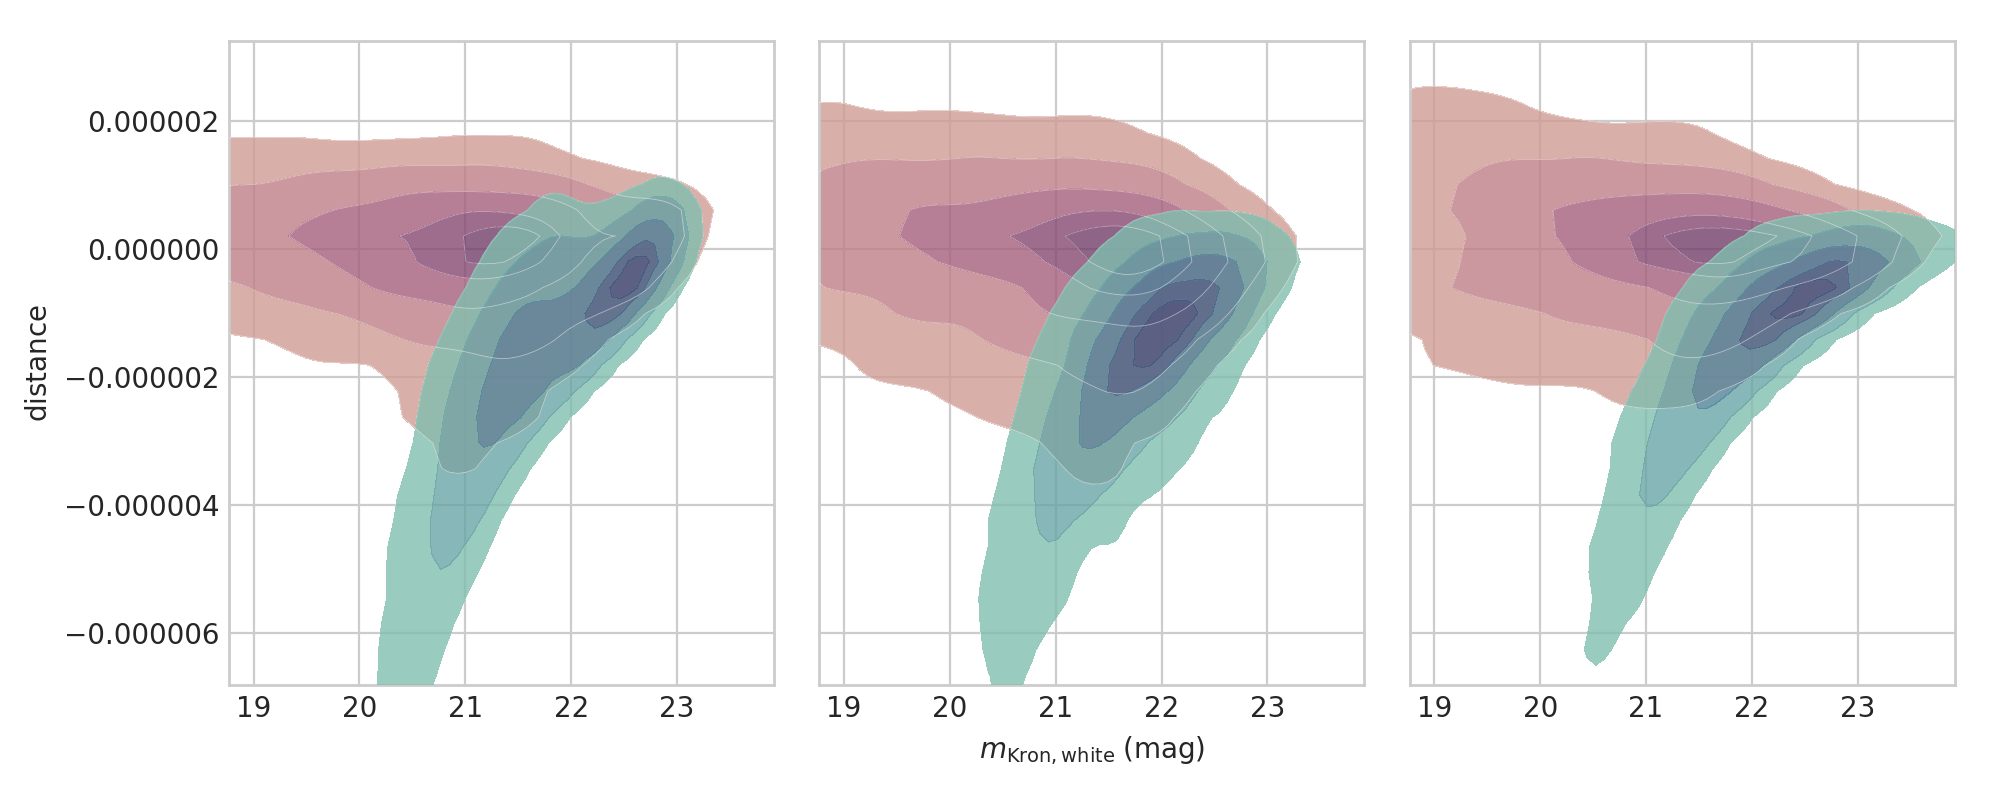

In [141]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_mean_psfap, ystar_mean_psfap, zstar_mean_psfap, xgal_mean_psfap, ygal_mean_psfap, zgal_mean_psfap), 
                                                                     (xstar_forced_psfap, ystar_forced_psfap, zstar_forced_psfap, xgal_forced_psfap, ygal_forced_psfap, zgal_forced_psfap), 
                                                                     (xstar_stacked_psfap, ystar_stacked_psfap, zstar_stacked_psfap, xgal_stacked_psfap, ygal_stacked_psfap, zgal_stacked_psfap)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 24)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

<IPython.core.display.Javascript object>


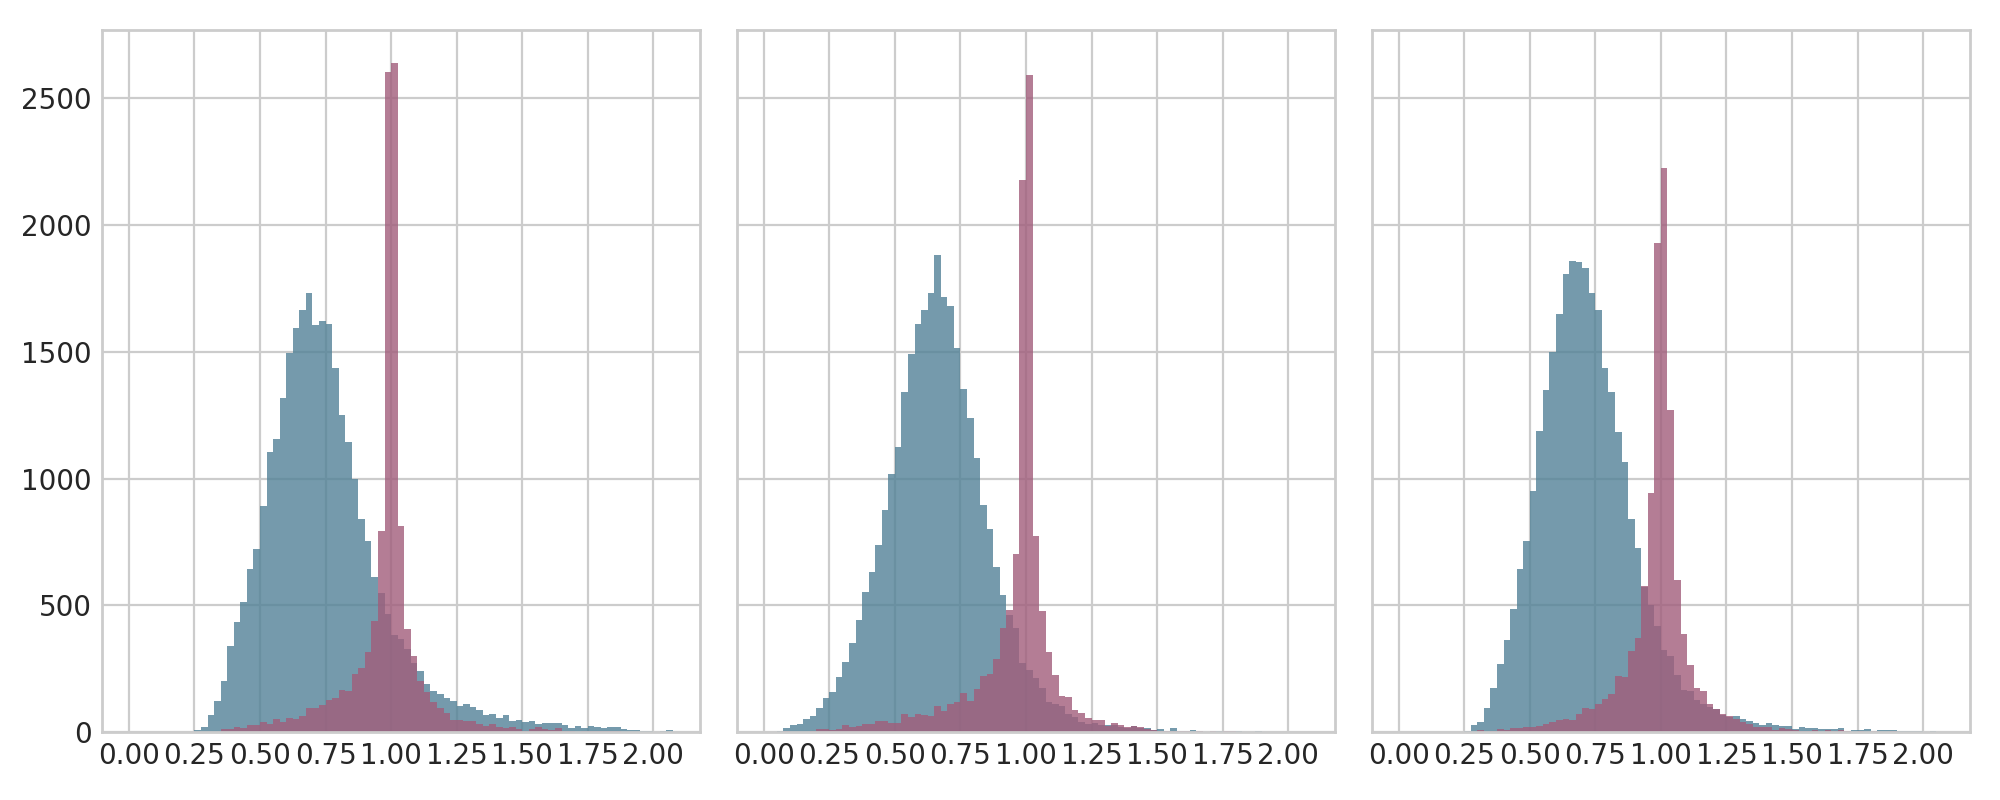

In [143]:
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, flux_ratio in enumerate([wwMeanPSFApRatio, wwFPSFApRatio, wwPSFApRatio]):
        axes[axnum].hist(flux_ratio[det_mfs_gal], 
                         alpha=0.8, bins=np.arange(0,2.1,0.025), 
                         color = cmap_gal(0.6))        
        axes[axnum].hist(flux_ratio[det_mfs_star], 
                         alpha=0.8, bins=np.arange(0,2.1,0.025), 
                         color = cmap_star(0.6))
    axes[0].set_xticks(np.linspace(0,2,9))

    fig.tight_layout()

## Determine the combo of data + slope to maximize TPR at FPR = 0.005

There are 4 numerical quantities that we care about, though ultimately we hope to maximize the TPR at FPR = 0.005.

In [11]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

def calc_distance(a, x, y): # model: y = ax
    a = np.array(a)
    model = (a*x).astype(float)
    wd = (y-model)/np.sqrt(1 + a**2)
    return np.array(wd)

def calc_accuracy(a, flux1, flux2, true_class):
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    pred_class = np.array((np.sign(delta)+1)/2, dtype = int)    # psf = kron >> gal
    acc = accuracy_score(true_class, pred_class)
    return acc

def calc_roc_auc(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    auc = roc_auc_score(true_class, delta)
    return auc

def calc_informedness_and_tpr(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)
    tpr_at_fpr005 = tpr[np.argmin(np.abs(fpr - 0.005))]
    return np.max(tpr-fpr), tpr_at_fpr005

def calc_roc_curve(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)    
    return fpr, tpr, thre

In [146]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["mean", "forced", "stacked"],
                        ["wwMean", "wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.ix[det_mfs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.ix[det_mfs]["{:s}KronFlux"], 
                                      ps1_df.ix[det_mfs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.ix[det_mfs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

<IPython.core.display.Javascript object>


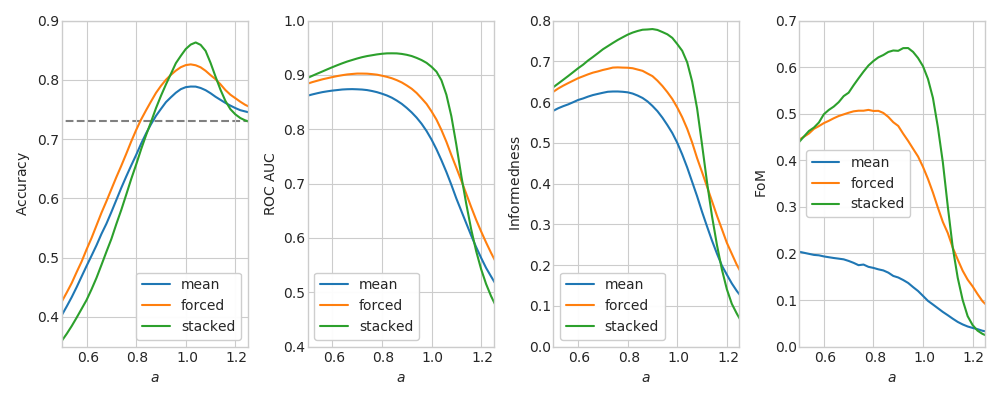

Max Acc = 0.8630 at a = 1.0400
Max AUC = 0.9396 at a = 0.8400
Max TPR-FPR = 0.7790 at a = 0.9000
Max FoM = 0.6409 at a = 0.9400


In [151]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["mean", "forced", "stacked"]:
        exec("axes[0].plot(a_grid, acc_{0}, label='{0}')".format(phot))
        exec("axes[1].plot(a_grid, auc_{0}, label='{0}')".format(phot))
        exec("axes[2].plot(a_grid, inform_{0}, label='{0}')".format(phot))
        exec("axes[3].plot(a_grid, fom_{0}, label='{0}')".format(phot))

    axes[3].set_xlim(0.5,1.25)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
        ax.legend(frameon=True, framealpha=0.95)
    axes[0].plot([0,2], [0.73, 0.73], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

Given that the dataset is dominated by faint sources, it should perhaps not be surprising that the PS1 stacked photometry clearly outperforms the other photometric methods (which have known issues at fainter brightness levels). 

Also interesting is that $a \approx 1$ maximizes each of the metrics that we are interested in determining. For the FoM, the variation near peak is strongly dependent on the selected value of $a$ - **the choice of this value should be confirmed via cross-validation.**

Below, we show that adopting $a = 0.94$ does not strongly degrade the other metrics considered for the simple model. Less than 1% for the ROC stats, and 6% for the accuracy (in particular this last choice leads to 

In [438]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.0618
Delta auc = -0.0091
Delta inform = -0.0093


**Examine same statistics for PSF and Ap Flux**

In [153]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["mean", "forced", "stacked"],
                        ["wwMean", "wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.ix[det_mfs]['{:s}ApFlux'], 
                                      ps1_df.ix[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.ix[det_mfs]["{:s}ApFlux"], 
                                      ps1_df.ix[det_mfs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.ix[det_mfs]['{:s}ApFlux'], 
                                      ps1_df.ix[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

<IPython.core.display.Javascript object>


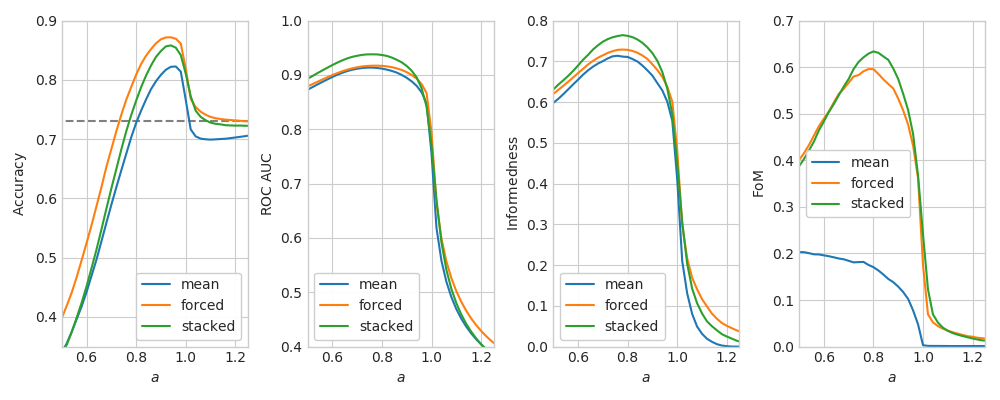

Max Acc = 0.8580 at a = 0.9400
Max AUC = 0.9377 at a = 0.7600
Max TPR-FPR = 0.7641 at a = 0.7800
Max FoM = 0.6336 at a = 0.8000


In [154]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["mean", "forced", "stacked"]:
        exec("axes[0].plot(a_grid, acc_{0}, label='{0}')".format(phot))
        exec("axes[1].plot(a_grid, auc_{0}, label='{0}')".format(phot))
        exec("axes[2].plot(a_grid, inform_{0}, label='{0}')".format(phot))
        exec("axes[3].plot(a_grid, fom_{0}, label='{0}')".format(phot))

    axes[3].set_xlim(0.5,1.25)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
        ax.legend(frameon=True, framealpha=0.95)
    axes[0].plot([0,2], [0.73, 0.73], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

The results when comparing the PSF and Ap photometry yield some interesting results. In particular, the separation between the use of the stacked photometry and the forced photometry is not as prominent (and in the case of overall model accuracy the forced photometry outperforms the stacked photometry).

Beyond that, while the performance of the simple model in the PSF-Ap plane is very similar to the PSF-Kron model, ultimately, the PSF-Kron model performs better (albeit at only a $\sim$1% improvement for the FoM).

As a result, **we conclude that PSF-Kron is the best model for separating stars and galaxies**. 

For completeness, below we examine the changes in the other metrics by adopting $a=0.8$, which maximizes the FoM.

In [155]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.1085
Delta auc = -0.0013
Delta inform = -0.0024


### Stacked Phot ROC curves

Having established that the stacked photometry is the best for PS1, we now examine the ROC curves for the four different metrics considered above.

<IPython.core.display.Javascript object>


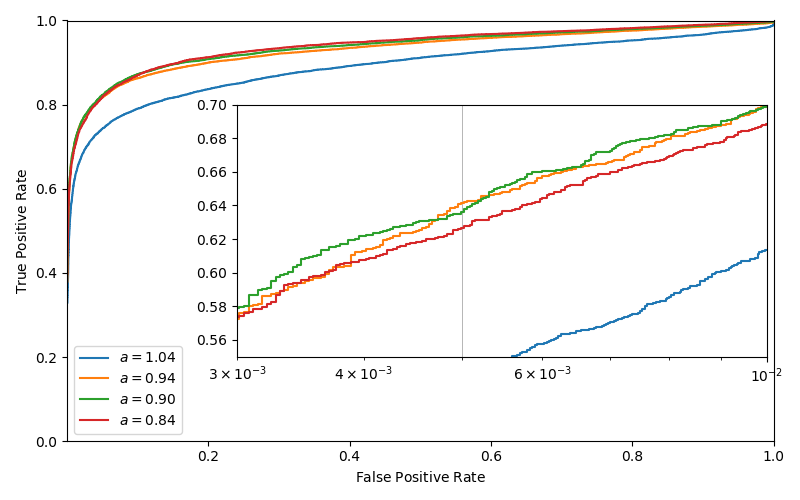

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [157]:
a_choice = [1.04, 0.94, 0.90, 0.84]

fig, ax = plt.subplots(figsize=(8,5))

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

for a in a_choice:
    fpr, tpr, thre = calc_roc_curve(a, ps1_df.ix[det_mfs]["wwKronFlux"], 
                                    ps1_df.ix[det_mfs]["wwPSFFlux"], 
                                    np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)
    ax.plot(fpr, tpr, label = r"$a = {:.2f}$".format(a))
    axins.plot(fpr, tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")
# axins.set_xlabel(r"$\mathrm{FPR}$")
# axins.set_ylabel(r"$\mathrm{TPR}$")

ax.legend()
fig.tight_layout()

From the ROC curves, it is clear that the performance at $a = 0.90$ is better than the FoM maximizing $a = 0.94$, aside from a small (noise?) spike exactly at FPR = 0.005. *This result should still be confirmed via CV or independent train-test split.*

**Thus, we adpot $a = 0.90$ as the optimal threshold for classifying PS1 stars and galaxies.**

To obtain FPR = 0.005 from this model requires a threshold of:

In [501]:
a = 0.90
fpr, tpr, thre = calc_roc_curve(a, ps1_df.ix[det_mfs]["wwKronFlux"], 
                                ps1_df.ix[det_mfs]["wwPSFFlux"], 
                                np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)
print("Sources with d > {:.8f} should be classified as stars".format(thre[np.argmin(np.abs(fpr - 0.005))]))


Sources with d > 0.00000185 should be classified as stars


# Part 2 - checking even the faintest sources

Below we will execute the same analysis, but this time using only sources detected in both the Forced and Stacked photometry from PS1. The primary difference for this sample is that it is a factor of $\sim$2 larger because the depth limits of the PS1 mean photometry are $\sim$1 mag more shallow than Forced and Stacked.

In [521]:
gal_dist_forced = ps1_df.ix[det_fs_gal]["FDist"]
gal_mag_forced = ps1_df.ix[det_fs_gal]["FKronMag"]

star_dist_forced = ps1_df.ix[det_fs_star]["FDist"]
star_mag_forced = ps1_df.ix[det_fs_star]["FKronMag"]

xgal_forced, ygal_forced, zgal_forced = kde_contour_dat(gal_mag_forced, gal_dist_forced, extent = (17,25.5,-4e-5,4e-5))
xstar_forced, ystar_forced, zstar_forced = kde_contour_dat(star_mag_forced, star_dist_forced, extent = (17,25.5,-4e-5,4e-5))

gal_dist_stacked = ps1_df.ix[det_fs_gal]["Dist"]
gal_mag_stacked = ps1_df.ix[det_fs_gal]["KronMag"]

star_dist_stacked = ps1_df.ix[det_fs_star]["Dist"]
star_mag_stacked = ps1_df.ix[det_fs_star]["KronMag"]

xgal_stacked, ygal_stacked, zgal_stacked = kde_contour_dat(gal_mag_stacked, gal_dist_stacked, extent = (17,25.5,-4e-5,4e-5))
xstar_stacked, ystar_stacked, zstar_stacked = kde_contour_dat(star_mag_stacked, star_dist_stacked, extent = (17,25.5,-4e-5,4e-5))

<IPython.core.display.Javascript object>


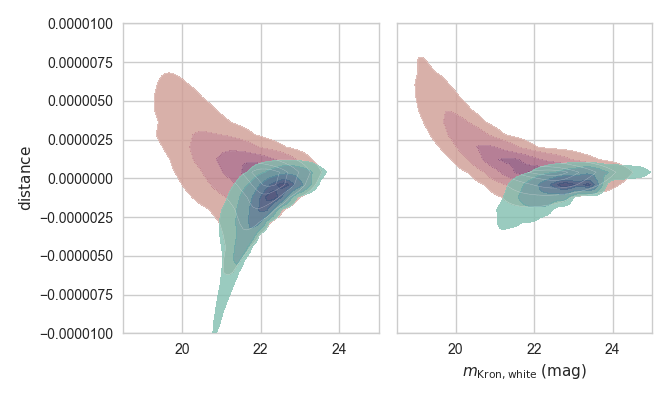

In [525]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (6.7, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_forced, ystar_forced, zstar_forced, 
                                                                      xgal_forced, ygal_forced, zgal_forced), 
                                                                     (xstar_stacked, ystar_stacked, zstar_stacked,
                                                                      xgal_stacked, ygal_stacked, zgal_stacked)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 25)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

In [526]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["forced", "stacked"],
                        ["wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.ix[det_fs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_fs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_fs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.ix[det_fs]["{:s}KronFlux"], 
                                      ps1_df.ix[det_fs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.ix[det_fs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.ix[det_fs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_fs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_fs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

<IPython.core.display.Javascript object>


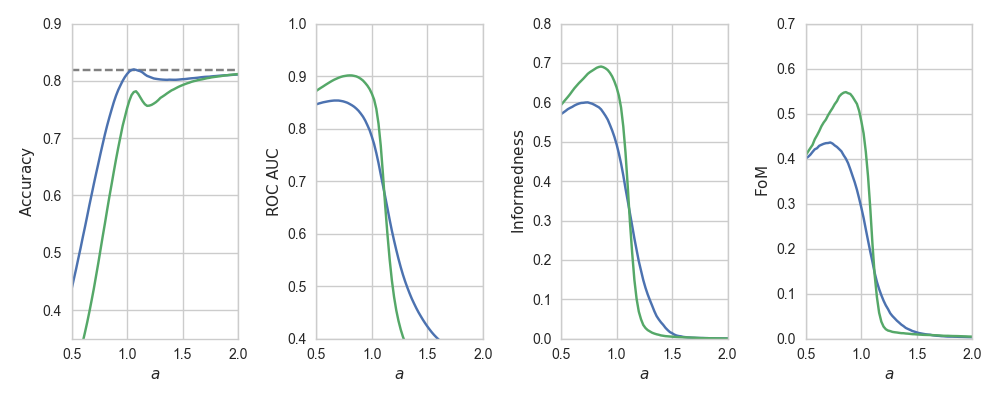

Max Acc = 0.8118 at a = 2.0000
Max AUC = 0.9012 at a = 0.8000
Max TPR-FPR = 0.6908 at a = 0.8600
Max FoM = 0.5477 at a = 0.8600


In [530]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["forced", "stacked"]:
        exec("axes[0].plot(a_grid, acc_{:s})".format(phot))
        exec("axes[1].plot(a_grid, auc_{:s})".format(phot))
        exec("axes[2].plot(a_grid, inform_{:s})".format(phot))
        exec("axes[3].plot(a_grid, fom_{:s})".format(phot))

    axes[3].set_xlim(0.5,2)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
    naive = len(det_fs_gal[0])/len(det_fs[0])
    axes[0].plot([0,2], [naive, naive], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

Because the new sample of faint sources is dominated by galaxies, we find that smaller values for $a$ do a better job with our preferred metrics. We also find that the simple model essentially does not outperform the naive model (i.e. all sources = galaxy).

In [531]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.2371
Delta auc = -0.0021
Delta inform = 0.0000


<IPython.core.display.Javascript object>


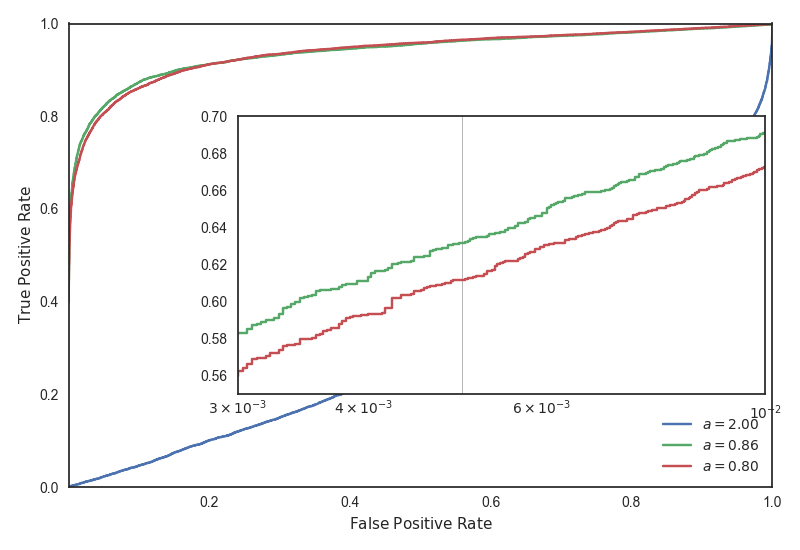

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [532]:
a_choice = [2, 0.86, 0.80]

fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

for a in a_choice:
    fpr, tpr, thre = calc_roc_curve(a, ps1_df.ix[det_mfs]["wwKronFlux"], 
                                    ps1_df.ix[det_mfs]["wwPSFFlux"], 
                                    np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)
    ax.plot(fpr, tpr, label = r"$a = {:.2f}$".format(a))
    axins.plot(fpr, tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")
# axins.set_xlabel(r"$\mathrm{FPR}$")
# axins.set_ylabel(r"$\mathrm{TPR}$")

ax.legend()
fig.tight_layout()

# Part 3

Perform cross-validation to determine the optimal value of $a$ for separating stars and galaxies.

In [8]:
from sklearn.model_selection import KFold

In [66]:
rs = 23
N_outter_splits = 10
a_grid = np.linspace(0.75, 1.25, 201)

dist_preds = np.empty_like(ps1_df.ix[det_mfs]['mu_class'])
tuned_a = np.empty(N_outter_splits)

kf_cv = KFold(n_splits=N_outter_splits, shuffle=True, random_state=rs)

for fold, (train, test) in zip(range(N_outter_splits), kf_cv.split(ps1_df.ix[det_mfs])):
    
    inform_train = np.empty(len(a_grid))
    fom_train = np.empty(len(a_grid))
    for i_a, a in enumerate(a_grid):
        inform_train[i_a], fom_train[i_a] = calc_informedness_and_tpr(a, np.array(ps1_df.ix[det_mfs]['wwKronFlux'])[train], 
                                      np.array(ps1_df.ix[det_mfs]['wwPSFFlux'])[train], 
                                      np.array(ps1_df.ix[det_mfs]['mu_class'], dtype = int)[train]-1)
        
    opt_a = a_grid[np.argmax(fom_train)]
    tuned_a[fold] = opt_a
    dist_preds[test] = calc_distance(opt_a, np.array(ps1_df.ix[det_mfs]['wwKronFlux'])[test], 
                                      np.array(ps1_df.ix[det_mfs]['wwPSFFlux'])[test])

<IPython.core.display.Javascript object>


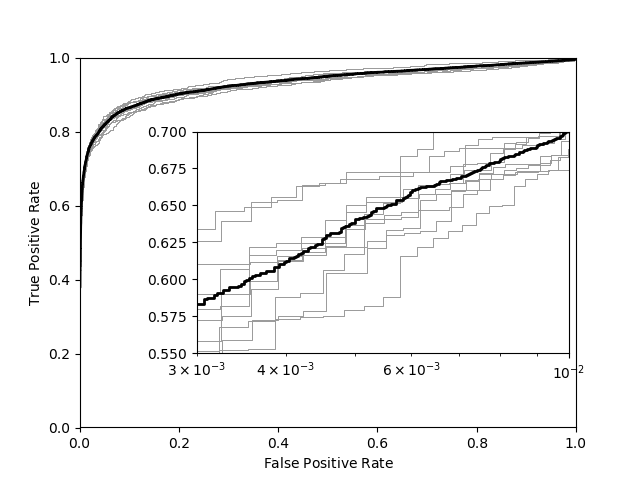

Optimal a = 0.9295


In [67]:
fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

print("Optimal a = {}".format(np.mean(tuned_a)))
fpr, tpr, thre = calc_roc_curve(np.mean(tuned_a), 
                                ps1_df.ix[det_mfs]['wwKronFlux'], 
                                ps1_df.ix[det_mfs]['wwPSFFlux'], 
                                np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)

ax.plot(fpr, tpr, "k", lw = 2, zorder=5, label = r"$a = {:.2f}$".format(a))
axins.plot(fpr, tpr, "k", lw = 2, zorder=5)

# plot up the individual folds
for train, test in kf_cv.split(ps1_df.ix[det_mfs]):
    fpr, tpr, thre = roc_curve(np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)[test]-1, dist_preds[test])
    ax.plot(fpr, tpr, '-', color="0.6", lw = 0.7)
    axins.plot(fpr, tpr, '-', color="0.6", lw = 0.7)

ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")

The above code performs an outter loop on the training set, which enables the use of all training set sources in the test phase. While there is considerable scatter in the FoM for the individual folds (light grey lines above), the optimal value of $a$ is $\sim$$0.93 \pm 0.01$ for all folds.

Thus, we adopt $a = 0.9295$ (found above) as the optimal model for our data set. 